## Libraries

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
import os, string
import numpy as np
import pandas as pd
from PIL import Image
import requests


import torch
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset
from peft import PeftModel, PeftConfig, LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load testing dataset

In [ ]:
image_path = "/content/drive/MyDrive/datasets/pokemon_png"
caption_path = "/content/drive/MyDrive/datasets/pokemon_caption.csv"

In [ ]:
#read caption file
caption_df = pd.read_csv(caption_path)

#tidy up columns
caption_df.drop(caption_df.columns[[0,1,3]],axis=1,inplace=True)
caption_df.columns = ['pokedex','image','caption_1','caption_2']

#remove tag, carriage return, punctuation, leading/trailing space from caption
caption_df["caption_1"] = caption_df["caption_1"].str.replace('<p class="version-x active">\n', "")
caption_df["caption_1"] = caption_df["caption_1"].str.replace('\n                </p>', "")
caption_df["caption_2"] = caption_df["caption_2"].str.replace('<p class="version-y">\n', "")
caption_df["caption_2"] = caption_df["caption_2"].str.replace('\n                </p>', "")

caption_df["caption_1"] = caption_df["caption_1"].str.translate(str.maketrans('', '', string.punctuation))
caption_df["caption_2"] = caption_df["caption_2"].str.translate(str.maketrans('', '', string.punctuation))

caption_df["caption_1"] = caption_df["caption_1"].str.strip()
caption_df["caption_2"] = caption_df["caption_2"].str.strip()

#add filename column
#caption_df['image'] = caption_df["image"].transform(lambda x: image_path + "/" + x[x.rindex('/')+1:].strip("0"))

#concatenate caption 1 and 2
df1 = caption_df[['image','caption_1']].rename(columns={'caption_1': 'text'})
df2 = caption_df[['image','caption_2']].rename(columns={'caption_2': 'text'})
dataset_df = pd.concat([df1,df2], ignore_index=True)

#drop caption rows with no image
dataset_df.reset_index(drop=True, inplace=True)

#check
display(dataset_df)

,image,text
0,https://assets.pokemon.com/assets/cms2/img/pok...,For some time after its birth it uses the nutr...
1,https://assets.pokemon.com/assets/cms2/img/pok...,The more sunlight Ivysaur bathes in the more s...
2,https://assets.pokemon.com/assets/cms2/img/pok...,While it basks in the sun it can convert the l...
3,https://assets.pokemon.com/assets/cms2/img/pok...,The flame on its tail shows the strength of it...
4,https://assets.pokemon.com/assets/cms2/img/pok...,When it swings its burning tail the temperatur...
...,...,...
2045,https://assets.pokemon.com/assets/cms2/img/pok...,It bears resemblance to a Pokémon that became ...
2046,https://assets.pokemon.com/assets/cms2/img/pok...,It was named after a mysterious object recorde...
2047,https://assets.pokemon.com/assets/cms2/img/pok...,There was supposedly an incident in which it l...
2048,https://assets.pokemon.com/assets/cms2/img/pok...,It’s thought that this Pokémon lived in ancien...


In [ ]:
def gen():
    for index, row in dataset_df.iterrows():
      yield {"text":row["text"], "image":Image.open(requests.get(row['image'], stream=True).raw)}
dataset = Dataset.from_generator(gen).shuffle(seed=123)
dataset = dataset.train_test_split(test_size=0.1, shuffle = False)

Generating train split: 0 examples [00:00, ? examples/s]

Even though it is filled with acid it does not melt because it also oozes a protective fluid


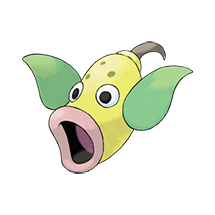

It stores flammable gas in its body and uses it to generate heat The yellow sections on its belly get particularly hot


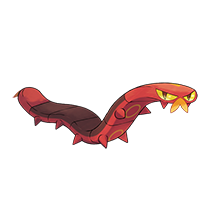

In [ ]:
print(dataset["train"][0]["text"])
display(dataset["train"][0]["image"])
print(dataset["test"][0]["text"])
display(dataset["test"][0]["image"])

## Load fine-tuned model and predict

In [ ]:
peft_model_id = "/content/drive/MyDrive/Pretrained Models/blip2_hard_4"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

In [ ]:
generated_captions = []
print(len(dataset["test"]))


for i, example in enumerate(dataset["test"]):
  print(i)
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  generated_captions.append(generated_caption)

205
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


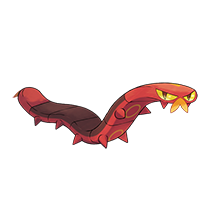

---------------------Actual----------------------
It stores flammable gas in its body and uses it to generate heat The yellow sections on its belly get particularly hot
--------------------Predicted--------------------
It is said that the red color of its body is the result of the blood of a fallen comrade who died in battle


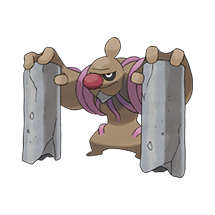

---------------------Actual----------------------
Rather than rely on their strength they master moves that make good use of centrifugal force to swing around concrete
--------------------Predicted--------------------
It is said that the stones were once used to build the walls of a city It is said that the stones were used to build the walls of a city


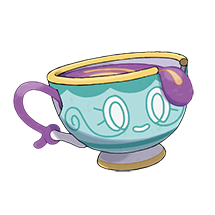

---------------------Actual----------------------
Sinistea gets into your body when you drink it and then it steals your vitality from within It also tastes awful
--------------------Predicted--------------------
It’s said that the tea in this cup is the best in the world It’s said that the tea in this cup is the best in the world


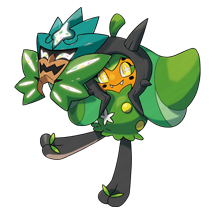

---------------------Actual----------------------
This Pokémon’s type changes based on which mask it’s wearing It confounds its enemies with nimble movements and kicks
--------------------Predicted--------------------
It’s said that the power of the sun is the power of the moon It’s said that the power of the sun is the power of the moon


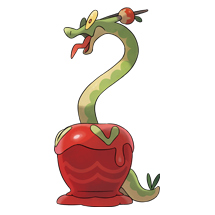

---------------------Actual----------------------
Seven syrpents live inside an apple made of syrup The syrpent in the center is the commander
--------------------Predicted--------------------
It is said that the apple it carries is the apple of the world It is said to be the apple of the world


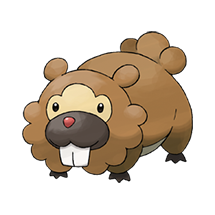

---------------------Actual----------------------
It constantly gnaws on logs and rocks to whittle down its front teeth It nests alongside water
--------------------Predicted--------------------
It is a very shy Pokémon It is said that it is afraid of the sun and will hide in the shade when it is exposed


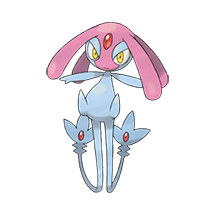

---------------------Actual----------------------
Known as “The Being of Emotion” It taught humans the nobility of sorrow pain and joy
--------------------Predicted--------------------
It is said that it is the most powerful Pokémon in the world It is said to be able to control the weather


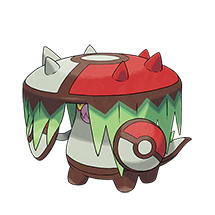

---------------------Actual----------------------
It is possible that the creature listed as Brute Bonnet in a certain book could actually be this Pokémon
--------------------Predicted--------------------
It is said that it was born in a cave in the mountains of the Galar region It is said to be a creature that lives in the dark and is said to be a ghostly being


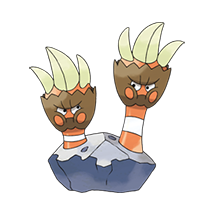

---------------------Actual----------------------
After two Binacle find a suitably sized rock they adhere themselves to it and live together They cooperate to gather food during high tide
--------------------Predicted--------------------
It’s said that the two Pokémon are related They’re said to be the same species


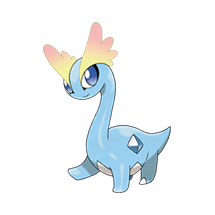

---------------------Actual----------------------
Amaura is an ancient Pokémon that has gone extinct Specimens of this species can sometimes be found frozen in ice
--------------------Predicted--------------------
It is said that it was born in a cave in the mountains of the Galar region It is said that it was found in a fossilized egg


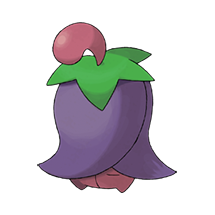

---------------------Actual----------------------
Its folded petals are pretty tough Bird Pokémon can peck at them all they want and Cherrim won’t be bothered at all
--------------------Predicted--------------------
It is said that the flower of this Pokémon is the most beautiful flower in the world


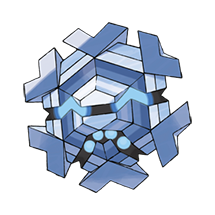

In [ ]:
for i, example in enumerate(dataset["test"]):
  display(example["image"])
  print('---------------------Actual----------------------')
  print(example["text"])
  print('--------------------Predicted--------------------')
  print(generated_captions[i])
  print("=================================================")
  if (i>10):
    break

In [ ]:
save_array = []
for i, example in enumerate(dataset["test"]):
  save_array.append([example["text"], generated_captions[i]])
save_array

dataframe = pd.DataFrame(save_array)
dataframe.to_csv("/content/drive/MyDrive/result/blip_hard_5.csv")

---------------------Actual----------------------
Cryogonal appear during cold seasons It is said that people and Pokémon who die on snowy mountains are reborn into these Pokémon
--------------------Predicted--------------------
It is said that the ice that makes up its body was once frozen water that was once part of the ocean


In [ ]:
save_array

[['It stores flammable gas in its body and uses it to generate heat The yellow sections on its belly get particularly hot',
  'It is said that the red color of its body is the result of the blood of a fallen comrade who died in battle'],
 ['Rather than rely on their strength they master moves that make good use of centrifugal force to swing around concrete',
  'It is said that the stones were once used to build the walls of a city It is said that the stones were used to build the walls of a city'],
 ['Sinistea gets into your body when you drink it and then it steals your vitality from within It also tastes awful',
  'It’s said that the tea in this cup is the best in the world It’s said that the tea in this cup is the best in the world'],
 ['This Pokémon’s type changes based on which mask it’s wearing It confounds its enemies with nimble movements and kicks',
  'It’s said that the power of the sun is the power of the moon It’s said that the power of the sun is the power of the moon'],
 